# Bitcoin analysis

bitcoin vs. sp500, and bitcoin vs. coinindex

## Extract BTC data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cryptocmd import CmcScraper
%matplotlib inline

# initialise scraper without time interval
scraper = CmcScraper("BTC")

btc_df = scraper.get_dataframe()
btc_df = pd.DataFrame(btc_df, columns=['Date','Close'])
btc_df.set_index('Date', inplace=True)
btc_df = btc_df.rename(columns = {'Close':'BTC'})
btc_df = btc_df.iloc[::-1]
btc_df.index = btc_df.index.tz_localize("UTC")
btc_df

,BTC
Date,
2013-04-28 00:00:00+00:00,134.210007
2013-04-29 00:00:00+00:00,144.539993
2013-04-30 00:00:00+00:00,139.000000
2013-05-01 00:00:00+00:00,116.989998
2013-05-02 00:00:00+00:00,105.209999
...,...
2022-03-06 00:00:00+00:00,38419.983377
2022-03-07 00:00:00+00:00,38062.040206
2022-03-08 00:00:00+00:00,38737.268495


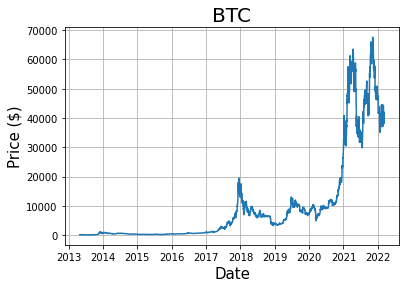

In [2]:
plt.plot(btc_df['BTC'])
plt.xlabel("Date", size=15)
plt.ylabel("Price ($)", size=15)
plt.title("BTC", size=20)
plt.grid()
plt.show()

Date
2013-04-28 00:00:00+00:00    0.000000
2013-04-29 00:00:00+00:00    0.076969
2013-04-30 00:00:00+00:00   -0.038328
2013-05-01 00:00:00+00:00   -0.158345
2013-05-02 00:00:00+00:00   -0.100692
                               ...   
2022-03-06 00:00:00+00:00   -0.024888
2022-03-07 00:00:00+00:00   -0.009317
2022-03-08 00:00:00+00:00    0.017740
2022-03-09 00:00:00+00:00    0.083786
2022-03-10 00:00:00+00:00   -0.060631
Name: BTC, Length: 3239, dtype: float64

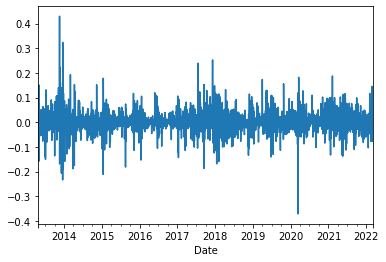

In [3]:
btc_daily_return = btc_df.pct_change().fillna(0).squeeze()
btc_daily_return.plot()
btc_daily_return

## Extract Coin Index

Use the first 10 cryptocurrency to build the coin index : $CoinIndex = \sum_{i=1}^{10}{Price_i \frac{MarketCap_i}{TotalCap}}$

In [ ]:
top_10_coins = ['BTC', 'ETH', 'USDT', 'BNB', 'USDC', 'XRP', 'LUNA', 'ADA', 'SOL', 'AVAX']

def scraper_top_10_coins(top_10_coins):
    all_coins_df = pd.DataFrame(columns=['Date'])
    for coins in top_10_coins:
        scraper = CmcScraper(coins)
        coins_df = scraper.get_dataframe()
        coins_df = pd.DataFrame(coins_df, columns=['Date','Close', 'Market Cap'])
        coins_df = coins_df.rename(columns = {'Close':coins+' Close'})
        coins_df = coins_df.rename(columns = {'Market Cap':coins+' Market Cap'})
        all_coins_df = all_coins_df.merge(coins_df, on='Date', how='outer')
    
    all_coins_df.set_index('Date', inplace=True)
    all_coins_df = all_coins_df.fillna(0)
    all_coins_df = all_coins_df.iloc[::-1]
    all_coins_df.index = all_coins_df.index.tz_localize("UTC")
    return all_coins_df

all_coins_df = scraper_top_10_coins(top_10_coins)
all_coins_df

In [ ]:
all_coins_df['Total Market Map'] = all_coins_df.loc[:, all_coins_df.columns.str.endswith('Market Cap')].sum(1)
all_coins_df['CoinIndex'] = np.zeros(len(all_coins_df))

def weighted_coins_index(top_10_coins, all_coins_df):
    for coins in top_10_coins:
        all_coins_df['CoinIndex'] = all_coins_df['CoinIndex'] + all_coins_df.apply(lambda x: x[coins+' Close'] * x[coins+' Market Cap'] / x['Total Market Map'], axis=1)
    
    return all_coins_df

weighted_coins_df = weighted_coins_index(top_10_coins, all_coins_df)
weighted_coins_df = weighted_coins_df.iloc[: , -1]
weighted_coins_df

In [ ]:
plt.plot(weighted_coins_df)
plt.xlabel("Date", size=15)
plt.ylabel("Price ($)", size=15)
plt.title("Coin index", size=20)
plt.grid()
plt.show()

In [ ]:
weighted_coins_return = weighted_coins_df.pct_change().fillna(0).squeeze()
weighted_coins_return.plot()
weighted_coins_return

## Extract SP500 data



In [ ]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2013, 4, 27)
end = datetime.datetime(2022, 3, 9)
SP500 = web.DataReader(['sp500'], 'fred', start, end)
SP500=SP500.rename(columns = {'sp500':'SP500'})
SP500.index = SP500.index.tz_localize("UTC")
SP500

In [ ]:
SP500['SP500'].plot(title='S&P 500 Price')

In [ ]:
sp500_daily_return = SP500['SP500'].pct_change(1).fillna(0)
sp500_daily_return
sp500_daily_return.plot()

In [ ]:
import pyfolio as pf
# silence warnings
import warnings
warnings.filterwarnings('ignore')

## BTC vs. SP500

In [ ]:
pf.create_returns_tear_sheet(btc_daily_return, benchmark_rets=sp500_daily_return, live_start_date='2020-01')
#pf.create_returns_tear_sheet(sp500_daily_return, benchmark_rets=btc_daily_return.squeeze())

## BTC vs. CoinIndex


In [ ]:
pf.create_returns_tear_sheet(btc_daily_return, benchmark_rets=weighted_coins_return, live_start_date='2020-01')